In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [34]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [35]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs
!mkdir -p outputs_grad_descent
!mkdir -p outputs_improved

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs_grad_descent already exists.
Error occurred while processing: outputs_grad_descent.


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs_improved already exists.
Error occurred while processing: outputs_improved.


# Generator

In [36]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [38]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [39]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [40]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [41]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [42]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [43]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [44]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [45]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

#### Ascend D gradient $$\nabla_{\theta_{d}} \big ( \cfrac{1}{m}  \sum_{i=1}^{m}  \log D(x^{(i)})  + \cfrac{1}{n_{z}} \sum_{i=1}^{n_{z}}  \log (1-D(G(z^{(i)})))\big )$$

In [47]:
torch.manual_seed(7777)

def generator_loss(output, descent=False):
    ############ YOUR CODE HERE ##########
    # Generator tries to make the discriminator output 1 for fake images if using gradient ascent 
    # Generator tries to make the drisciminator output 0 for gradient descent 
    if descent:
        # When using gradient descent, minimize log(1 - D(G(z)))
        # This approach penalizes the generator more as it improves
        #labels = torch.zeros_like(output, device=output.device)
        #loss = criterion(output, labels)
        loss = torch.mean(torch.log(1 - output))  # clamp to avoid log(0)
        return loss  # Negative sign because we're doing descent
    else:
        # Traditional approach: maximize log(D(G(z)))
        # The generator tries to make the discriminator output 1 for fake images
        labels = torch.ones_like(output, device=output.device)
        return criterion(output, labels)

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    # Discriminator tries to correctly classify real and fake images
    criterion = nn.BCELoss()
    return criterion(output, true_label)
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        # One batch
        # bi is number of times looped 
        # data[0] is 512 (batch size) inputs x1,...,x512 
        # data[1] is 512 with label 0-9

        # sample mini batch of nz noise samples
        # Sample mini batch of {x1,...,xm} -> "data"
        
        # Train Discriminator
        # Real Images
        real_images = data[0].to(device)
        labels_real = torch.ones(len(real_images), 1, device=device)
        outputs_real = discriminator.forward(real_images)
        loss_d_real = discriminator_loss(outputs_real, labels_real)
        
        # Fake Images
        # noise_batch = torch.randn(batch_size, nz, 1, 1, device=device)
        noise_batch = torch.randn(batch_size, nz).to(device)
        fake_images = generator.forward(noise_batch)
        labels_fake = torch.zeros(batch_size, 1, device=device)
        outputs_fake = discriminator.forward(fake_images.detach())
        loss_d_fake = discriminator_loss(outputs_fake, labels_fake)

        # Combine losses and update discriminator
        loss_d_total = loss_d_real + loss_d_fake
        optim_d.zero_grad()
        loss_d_total.backward()
        optim_d.step()

        # Train Generator
        outputs_fake = discriminator.forward(fake_images) # comment out? 
        # loss_g = generator_loss(outputs_fake) # gradient ascent 
        loss_g = generator_loss(outputs_fake, descent=True) # gradient descent
        optim_g.zero_grad()
        loss_g.backward()
        optim_g.step()

        # Update running loss totals
        loss_g += loss_g.item()
        loss_d += loss_d_total.item()

        ######################################
     
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch == 0):
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs_grad_descent/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

  0%|          | 0/117 [00:00<?, ?it/s]

  3%|▎         | 4/117 [00:35<16:47,  8.91s/it]  


KeyboardInterrupt: 

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs_grad_descent/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs_grad_descent/generator_images.gif', imgs)

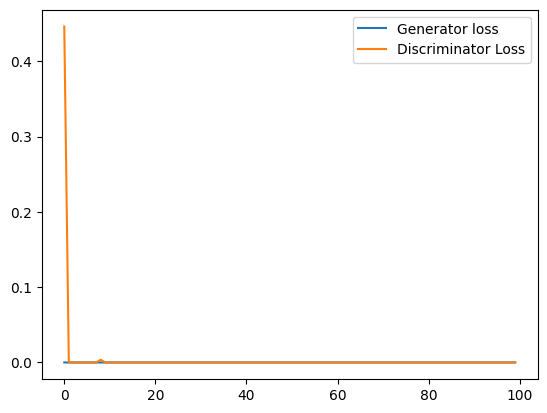

In [17]:
# plot and save the generator and discriminator loss
def convert_to_floats(lst):
    float_list = []
    for item in lst:
        # Check if the item is a tensor
        if torch.is_tensor(item):
            # Convert tensor to a Python float
            float_list.append(item.item())
        else:
            # Convert to float if it's not a tensor
            float_list.append(float(item))
    return float_list

losses_d = convert_to_floats(losses_d)
losses_g = convert_to_floats(losses_g)

plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs_grad_descent/loss.png')

In [18]:
len(losses_d)

100